En esta sección se calcularán dos rectas de Bouger, para los filtros V y B, usando las estrellas estándar del campo y los datos reducidos en el Notebook anterior. Primeramente se importarán paquetes y funciones de utilidad.

In [1]:
import aplpy
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit
from astropy.wcs import WCS
import re
import ccdproc as ccdp
from astropy.nddata import CCDData
from astropy import units as u
import photutils as pht
from photutils.profiles import RadialProfile
from scipy.ndimage import rotate

In [2]:
def zoom(RA,DEC,tamano_corte,header,data):
  """
  Función que recorta la imagen y genera un zoom.

  Parámetros:
    RA: str, Coordenada RA.
    DEC: str, Coordenada DEC.
    tamano_corte: int.
    header: var, header del RAW.
    data: var, data del RAW.
  """
  # ==========================================================
  # Cambio de coordenadas celestiales a coordenadas pixelares.
  # ==========================================================

  w = wcs.WCS(header)
  coords = SkyCoord(RA,DEC,frame='icrs') # Variable que guarda ambas coordenadas.
  x_pix, y_pix = w.wcs_world2pix(coords.ra.deg, coords.dec.deg, 1) # Conversión

  # ==============================================================
  # Recorte de la imagen según el tamaño indicado y visualización.
  # ==============================================================

  cut_data = data[int(y_pix-tamano_corte/2):int(y_pix+tamano_corte/2),
                  int(x_pix-tamano_corte/2):int(x_pix+tamano_corte/2)]
  return cut_data

In [3]:
def _to_identifier(label):
    """
    Convierte la etiqueta en un identificador Python válido.
    Reemplaza caracteres no alfanuméricos por guiones bajos.

    Parámetros:
      label: str, etiqueta a convertir.
    """
    # Reemplaza no alfanum por _.
    s = re.sub(r'\W', '_', str(label))      
    if s and s[0].isdigit():
        s = '_' + s # La etiqueta no puede empezar con dígitos.                        
    return s or 'etiqueta'

def datos_fits(ruta_del_archivo, etiqueta_del_archivo, ext=1, register_globals=True, memmap=True):
    """
    Abre un FITS y crea variables globales nombradas con la etiqueta:
      hdu_{etiqueta}, header_{etiqueta}, data_{etiqueta}, w_{etiqueta}
    También retorna un dict con esas referencias.

    Parámetros:
      ruta_del_archivo: str, ruta al FITS.
      etiqueta_del_archivo: str, e.g.' _bias1'.
      ext: int, extensión a usar (por defecto 1).
      register_globals: bool, si: True, crea variables globales.
      memmap: bool, si: True, utiliza mapeo a memoria.

    Nota: cierra el HDUList con hdu_{etiqueta}.close() cuando termines.
    """
    etiqueta = _to_identifier(etiqueta_del_archivo)

    hdul = fits.open(ruta_del_archivo, memmap=memmap)
    try:
        hdu = hdul[ext]
    except IndexError:
        hdul.close()
        raise ValueError(f"El archivo no tiene la extensión {ext}.")

    header = hdu.header
    data = hdu.data
    w = WCS(header)

    if register_globals:
        g = globals()
        g[f"hdu_{etiqueta}"] = hdul
        g[f"header_{etiqueta}"] = header
        g[f"data_{etiqueta}"] = data
        g[f"w_{etiqueta}"] = w

    return

In [4]:
def imagen(data):
  '''
  Función que visualiza una imagen.
  '''
  f = aplpy.FITSFigure(data)
  f.show_grayscale()
  return

In [5]:
def zoom(RA,DEC,tamano_corte,header,data):
  """
  Función que recorta la imagen y genera un zoom.

  Parámetros:
    RA: str, Coordenada RA.
    DEC: str, Coordenada DEC.
    tamano_corte: int.
    header: var, header del RAW.
    data: var, data del RAW.
  """
  # ==========================================================
  # Cambio de coordenadas celestiales a coordenadas pixelares.
  # ==========================================================

  w = wcs.WCS(header)
  coords = SkyCoord(RA,DEC,frame='icrs') # Variable que guarda ambas coordenadas.
  x_pix, y_pix = w.wcs_world2pix(coords.ra.deg, coords.dec.deg, 1) # Conversión

  # ==============================================================
  # Recorte de la imagen según el tamaño indicado y visualización.
  # ==============================================================

  cut_data = data[int(y_pix-tamano_corte/2):int(y_pix+tamano_corte/2),
                  int(x_pix-tamano_corte/2):int(x_pix+tamano_corte/2)]
  return cut_data

In [6]:
def apert_fot_mag(data,header,coord_x,coord_y,apertura,ancho_anillo,offset_apertura_out):

  # =======================
  # Definición de regiones.
  # =======================

  # Se define una apertura centrada en la estrella cuyo radio es el máximo que aporta a la fotometría.
  apertura_estrella = pht.aperture.CircularAperture((coord_x,coord_y),r=apertura)

  # Se define un anillo externo a la estrella, de donde se calculará el flujo percibido en esa zona para posteriormente sustraerlo
  # del flujo en la apertura centrada en la estrella. Los radios internos y externos se definen mediante las relaciones citadas.
  # R_in \approx (1.5-2.0)R_max; R_out \approx \Delta R_in
  radio_interno = 2.0*apertura
  radio_externo = radio_interno+ancho_anillo
  apertura_anillo = pht.aperture.CircularAnnulus((coord_x,coord_y),r_in=radio_interno,r_out=radio_externo)

  # Se define una apertura del mismo radio pero desplazada con respecto a la estrella de interés con el fin
  # de determinar el flujo en una region vacia.
  apertura_out = pht.aperture.CircularAperture((coord_x-offset_apertura_out,coord_y),r=apertura)

  # Se grafican las aperturas y anillo indicado.
  plt.imshow(data, interpolation='nearest', cmap='inferno', origin='lower')
  plt.xlabel('Pixels')
  plt.ylabel('Pixels')
  apertura_estrella.plot(color='white', lw=2, label='Apertura de Fotometría')
  apertura_anillo.plot(color='red', lw=2, label='Anillo Background')
  apertura_out.plot(color='yellow', lw=2, label='Apertura Background')
  plt.legend()
  plt.show()

  # =========================================
  # Cálculo de flujo y magnitud instrumental.
  # =========================================

  # Suma de pixeles del anillo
  anillo = pht.aperture.ApertureStats(data,apertura_anillo,sum_method='exact')
  # Promedio de cuentas en el anillo * área de apertura de la extrella
  # (flujo neto con método del anillo).
  suma_anillo = anillo.mean*apertura_estrella.area_overlap(data)

  # Se calcula el flujo total de la apertura sobre el fondo.
  suma_apertura_out = pht.aperture.aperture_photometry(data,apertura_out)

  # Se calcula el flujo total de la apertura sobre la estrella
  suma_apertura = pht.aperture.aperture_photometry(data,apertura_estrella)

  # Flujo de cada método
  flujo_sin_anillo = suma_apertura['aperture_sum'] - suma_anillo
  flujo_sin_out = suma_apertura['aperture_sum'] - suma_apertura_out['aperture_sum']

  # Se calcula la magnitud instrumental a partir del número de cuentas obtenido para cada método.
  mag_anillo = -2.5*np.log10(flujo_sin_anillo[0]/header['EXPTIME'])
  mag_offset = -2.5*np.log10(flujo_sin_out[0]/header['EXPTIME'])
  airmass = header['AIRMASS']
  return print(f'Magnitud con anillo: {mag_anillo}, Magnitud con offset: {mag_offset}, Airmass: {airmass}')

In [7]:
def cambiacoordenadas(RA,DEC,header):
    '''
    Función que convierte coordenadas celestiales a coordenadas pixelares.

    Parámetros:
        RA: str, Coordenada RA.
        DEC: str, Coordenada DEC.
        header: var, header del RAW.
    '''
    w = wcs.WCS(header)
    coords = SkyCoord(RA,DEC,frame='icrs') # Variable que guarda ambas coordenadas.
    x_pix, y_pix = w.wcs_world2pix(coords.ra.deg, coords.dec.deg, 1) # Conversión
    return float(x_pix), float(y_pix)

Las estrellas estándares son:
- PG0942-029
- PG0942-029A
- PG0942-029B
- PG0942-029C
- PG0942-029D

En el link https://www.eso.org/sci/observing/tools/standards/Landolt.html se encuentran con sus respectivas coordenadas.
Estas coordenadas fueron mejoradas en precisión usando las coordenadas RA: $09:45:11.906$ y DEC: $-03:09:21.87$ extraídas del header de los archivos BANZAI, centrándola y buscando en un radio de $13[arcmin]$. En este link se encuentran las estrellas: https://simbad.cds.unistra.fr/simbad/sim-coo?Coord=09%3A45%3A11.906+-03%3A09%3A21.87&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=13&Radius.unit=arcmin&submit=submit+query&CoordList=

In [8]:
ruta_BANZAI_189 = 'C:/Users/Tom/Desktop/UdeC/2025-2/Astro. Observacional/Observacional VSCode/BANZAIs/coj1m011-fa12-20241223-0189-e91.fits.fz'
datos_fits(ruta_BANZAI_189, 'BANZAI_189')

ruta_BANZAI_190 = 'C:\\Users\\Tom\\Desktop\\UdeC\\2025-2\\Astro. Observacional\\Observacional VSCode\\BANZAIs\\coj1m011-fa12-20241223-0190-e91.fits.fz'
datos_fits(ruta_BANZAI_190, 'BANZAI_190')

ruta_BANZAI_193 = 'C:/Users/Tom/Desktop/UdeC/2025-2/Astro. Observacional/Observacional VSCode/BANZAIs/coj1m011-fa12-20241223-0193-e91.fits.fz'
datos_fits(ruta_BANZAI_193, 'BANZAI_193')

ruta_BANZAI_194 = 'C:/Users/Tom/Desktop/UdeC/2025-2/Astro. Observacional/Observacional VSCode/BANZAIs/coj1m011-fa12-20241223-0194-e91.fits.fz'
datos_fits(ruta_BANZAI_194, 'BANZAI_194')

ruta_BANZAI_197 = 'C:/Users/Tom/Desktop/UdeC/2025-2/Astro. Observacional/Observacional VSCode/BANZAIs/coj1m011-fa12-20241223-0197-e91.fits.fz'
datos_fits(ruta_BANZAI_197, 'BANZAI_197')

ruta_BANZAI_198 = 'C:/Users/Tom/Desktop/UdeC/2025-2/Astro. Observacional/Observacional VSCode/BANZAIs/coj1m011-fa12-20241223-0198-e91.fits.fz'
datos_fits(ruta_BANZAI_198, 'BANZAI_198')

ruta_BANZAI_201 = 'C:/Users/Tom/Desktop/UdeC/2025-2/Astro. Observacional/Observacional VSCode/BANZAIs/coj1m011-fa12-20241223-0201-e91.fits.fz'
datos_fits(ruta_BANZAI_201, 'BANZAI_201')

ruta_BANZAI_202 = 'C:/Users/Tom/Desktop/UdeC/2025-2/Astro. Observacional/Observacional VSCode/BANZAIs/coj1m011-fa12-20241223-0202-e91.fits.fz'
datos_fits(ruta_BANZAI_202, 'BANZAI_202')

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Estas son las coordenadas pixelares de las estrellas estándares del campo. Notar que en argumento de la función se encuentran las coordenadas RA y DEC, respectivamente, cuya data fue extraída directamente de los links mencionados anteriormente.

In [11]:
print(cambiacoordenadas('09h45m11.8538082624s','-03d09m21.034933164s',header_BANZAI_189))
print(cambiacoordenadas('09h45m09.9066572376s','-03d10m14.256881976s',header_BANZAI_189))
print(cambiacoordenadas('09h45m11.5754495232s','-03d06m58.161859488s',header_BANZAI_189))
print(cambiacoordenadas('09h45m14.3872897872s','-03d06m40.292956080s',header_BANZAI_189))
print(cambiacoordenadas('09h45m08.6375086464s','-03d05m54.473902440s',header_BANZAI_189))

(1972.7748200036472, 2031.2741010723619)
(1896.2285642581294, 2166.9385986963175)
(1966.637396476835, 1664.4532824580006)
(2075.2984660530997, 1619.9377732809676)
(1855.7319277073107, 1499.5916627403235)


Se marcarán las estrellas en el campo para identificarlas.

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -1.819e+01 [aplpy.core]
INFO: Auto-setting vmax to  6.294e+01 [aplpy.core]


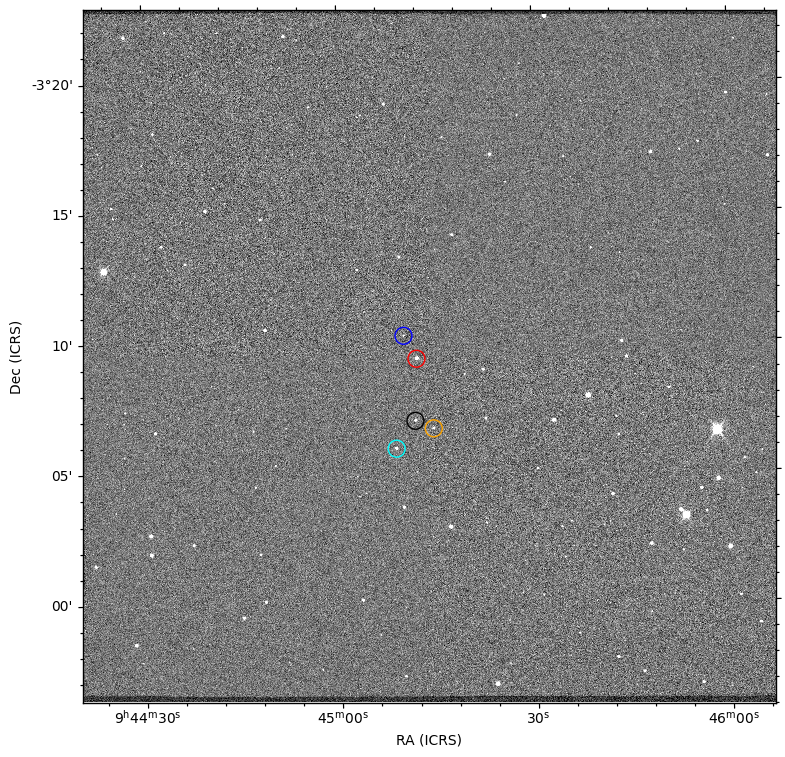

In [113]:
f = aplpy.FITSFigure(hdu_BANZAI_189[1])
f.show_grayscale()

# PG0942-029
f.show_circles(1972.7748200036472, 2031.2741010723619, coords_frame='pixel', color='red', radius=50) #Central

# PG0942-029A
f.show_circles(1896.2285642581294, 2166.9385986963175, coords_frame='pixel', color='blue', radius=50)

# PG0942-029B
f.show_circles(1966.637396476835, 1664.4532824580006, coords_frame='pixel', color='black', radius=50)

# PG0942-029C
f.show_circles(2075.2984660530997, 1619.9377732809676, coords_frame='pixel', color='orange', radius=50)

# PG0942-029D
f.show_circles(1855.7319277073107, 1499.5916627403235, coords_frame='pixel', color='cyan', radius=50)

Se realizará un zoom a cada una para visualizarla de mejor manera.

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -3.802e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.116e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.062e+01 [aplpy.core]
INFO: Auto-setting vmax to  9.296e+01 [aplpy.core]


INFO: Auto-setting vmin to -2.609e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.029e+02 [aplpy.core]


INFO: Auto-setting vmin to -1.528e+01 [aplpy.core]
INFO: Auto-setting vmax to  8.333e+01 [aplpy.core]


INFO: Auto-setting vmin to -3.343e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.980e+02 [aplpy.core]


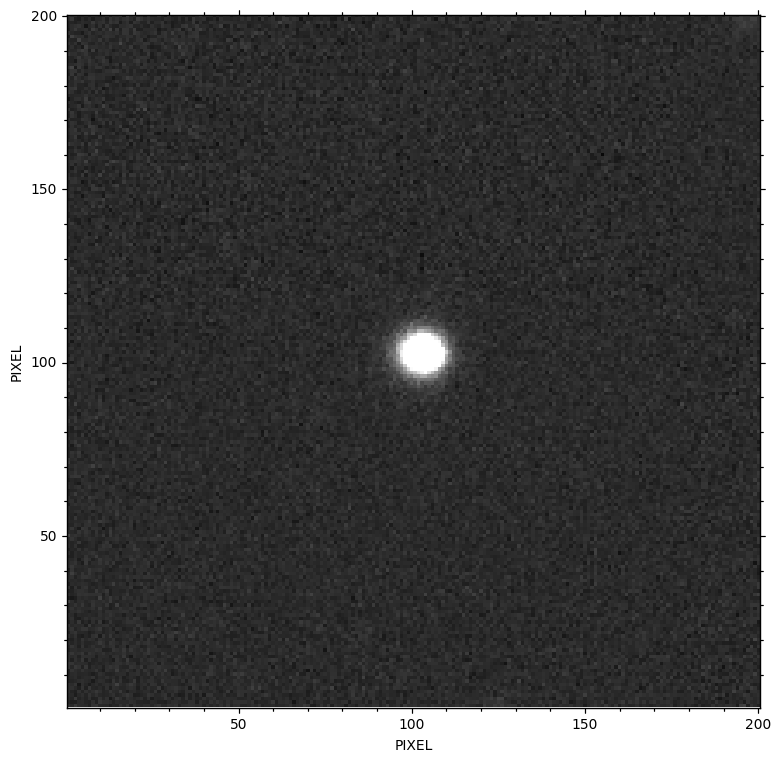

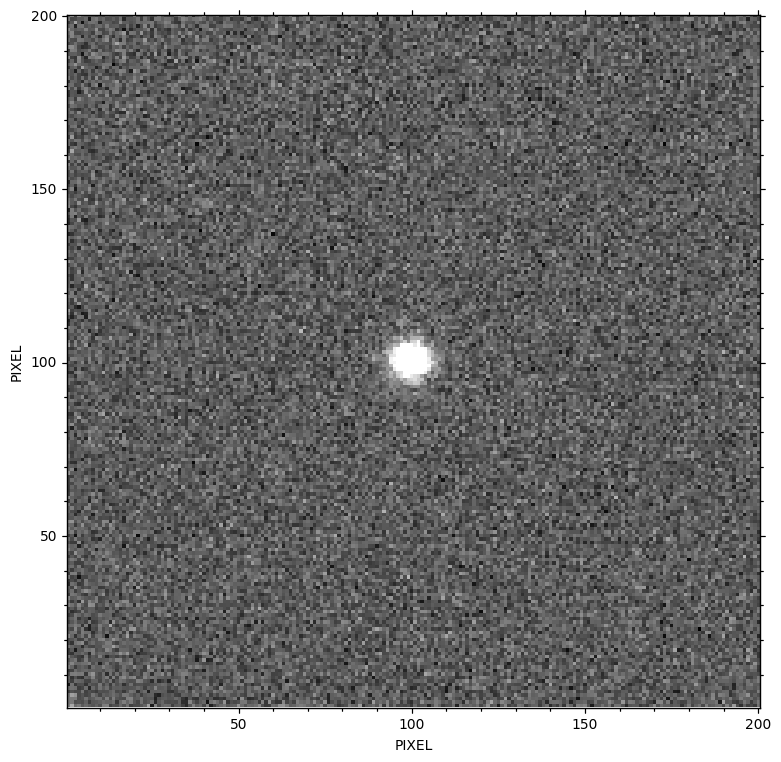

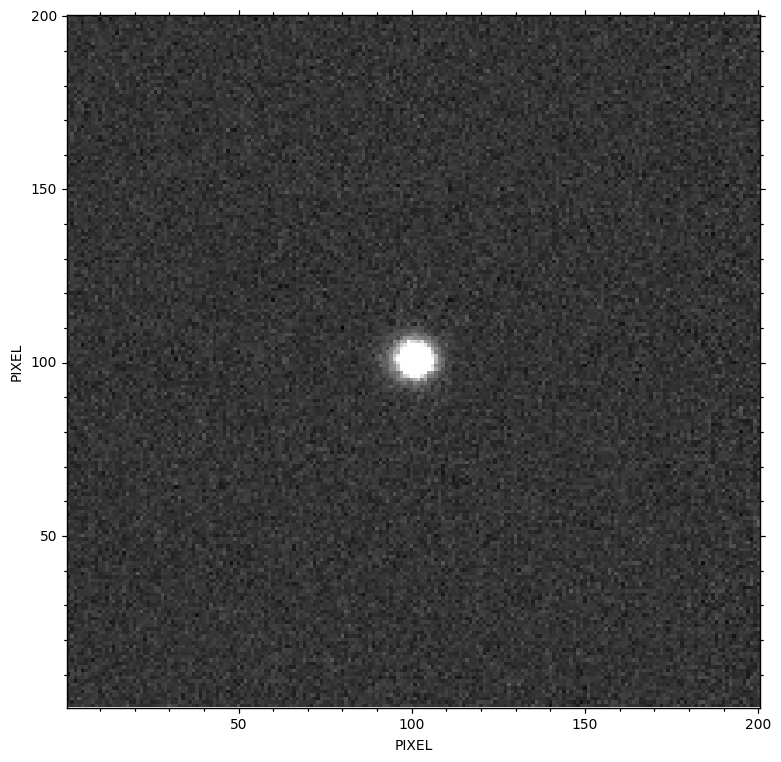

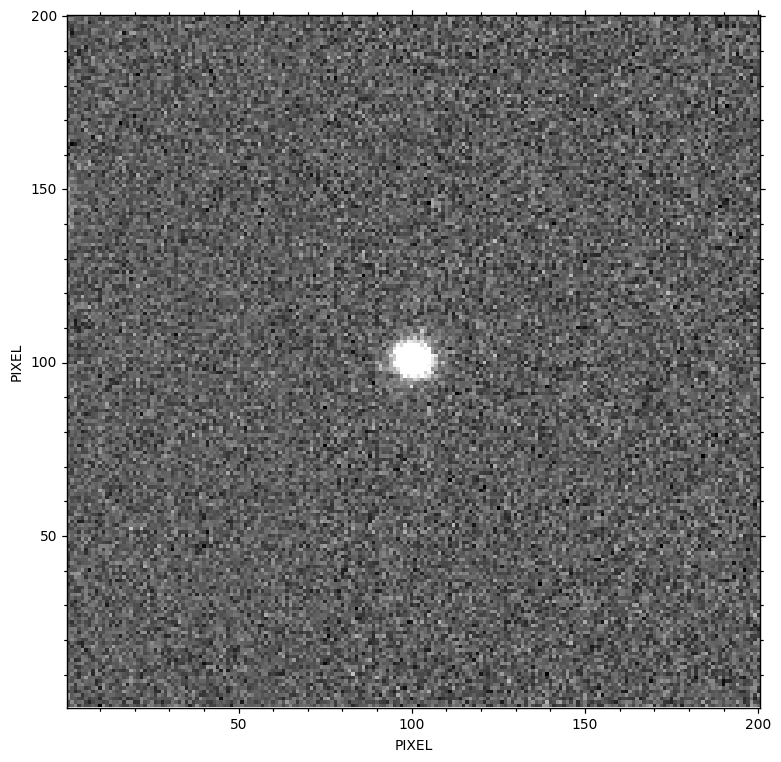

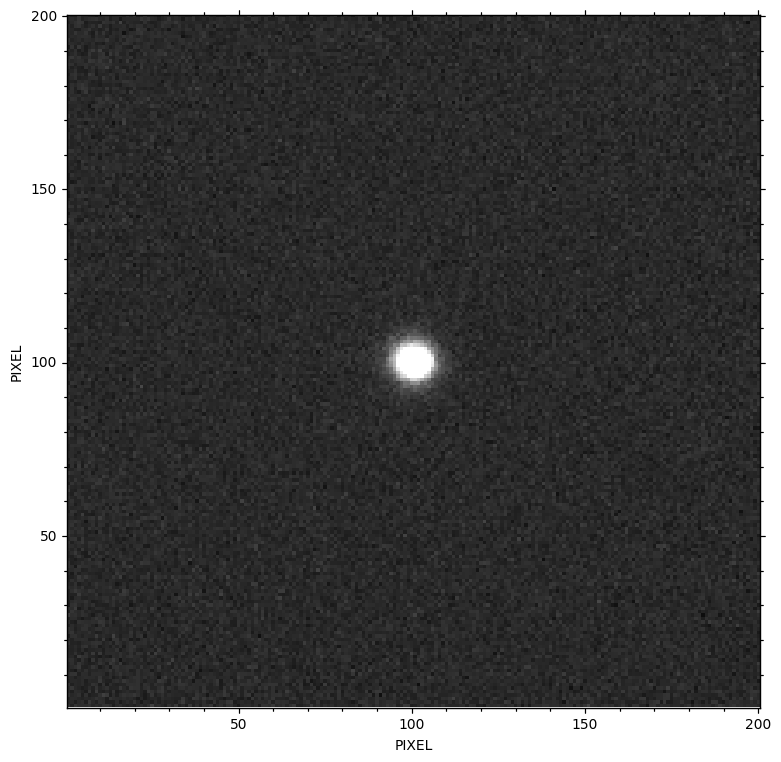

In [ ]:
estrella_1 = zoom('09h45m11.8538082624s', '-03d09m21.034933164s', 200, header_BANZAI_189, data_BANZAI_189)
estrella_2 = zoom('09h45m09.9066572376s', '-03d10m14.256881976s', 200, header_BANZAI_189, data_BANZAI_189)
estrella_3 = zoom('09h45m11.5754495232s', '-03d06m58.161859488s', 200, header_BANZAI_189, data_BANZAI_189)
estrella_4 = zoom('09h45m14.3872897872s', '-03d06m40.292956080s', 200, header_BANZAI_189, data_BANZAI_189)
estrella_5 = zoom('09h45m08.6375086464s', '-03d05m54.473902440s', 200, header_BANZAI_189, data_BANZAI_189)

imagen(estrella_1)
imagen(estrella_2)
imagen(estrella_3)
imagen(estrella_4)
imagen(estrella_5)

Ahora, se hará carga de los archivos reducidos calculados en la sección $Reducción$ para posteriormente realizar el cálculo de magnitud de las 5 estrellas en cada filtro y crear la recta de Bouger. Notar que se utilizará el header del archvio BANZAI asociado debido a que contiene la correcta transformación de coordenadas en WCS para dejar centrada la estrella y los valores para 'EXPTIME', 'FILTER' y 'AIRMASS' son idénticos al archivo RAW asociado.

In [100]:
ruta_clean_189 = 'C:\\Users\\Tom\\Desktop\\UdeC\\2025-2\\Astro. Observacional\\Observacional VSCode\\Clean Data\\campo_reducido_189_con_header.fits'
datos_fits(ruta_clean_189,'clean_189',ext=0,memmap=False)

ruta_clean_190 = 'C:\\Users\\Tom\\Desktop\\UdeC\\2025-2\\Astro. Observacional\\Observacional VSCode\\Clean Data\\campo_reducido_190_con_header.fits'
datos_fits(ruta_clean_190,'clean_190',ext=0,memmap=False)

ruta_clean_193 = 'C:\\Users\\Tom\\Desktop\\UdeC\\2025-2\\Astro. Observacional\\Observacional VSCode\\Clean Data\\campo_reducido_193_con_header.fits'
datos_fits(ruta_clean_193,'clean_193',ext=0,memmap=False)

ruta_clean_194 = 'C:\\Users\\Tom\\Desktop\\UdeC\\2025-2\\Astro. Observacional\\Observacional VSCode\\Clean Data\\campo_reducido_194_con_header.fits'
datos_fits(ruta_clean_194,'clean_194',ext=0,memmap=False)

ruta_clean_197 = 'C:\\Users\\Tom\\Desktop\\UdeC\\2025-2\\Astro. Observacional\\Observacional VSCode\\Clean Data\\campo_reducido_197_con_header.fits'
datos_fits(ruta_clean_197,'clean_197',ext=0,memmap=False)

ruta_clean_198 = 'C:\\Users\\Tom\\Desktop\\UdeC\\2025-2\\Astro. Observacional\\Observacional VSCode\\Clean Data\\campo_reducido_198_con_header.fits'
datos_fits(ruta_clean_198,'clean_198',ext=0,memmap=False)

ruta_clean_201 = 'C:\\Users\\Tom\\Desktop\\UdeC\\2025-2\\Astro. Observacional\\Observacional VSCode\\Clean Data\\campo_reducido_201_con_header.fits'
datos_fits(ruta_clean_201,'clean_201',ext=0,memmap=False)

ruta_clean_202 = 'C:\\Users\\Tom\\Desktop\\UdeC\\2025-2\\Astro. Observacional\\Observacional VSCode\\Clean Data\\campo_reducido_202_con_header.fits'
datos_fits(ruta_clean_202,'clean_202',ext=0,memmap=False)

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


no pescar

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -3.095e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.477e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.593e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.555e+02 [aplpy.core]


INFO: Auto-setting vmin to -1.484e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.053e+01 [aplpy.core]


INFO: Auto-setting vmin to -2.051e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.067e+02 [aplpy.core]


INFO: Auto-setting vmin to -1.851e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.220e+02 [aplpy.core]


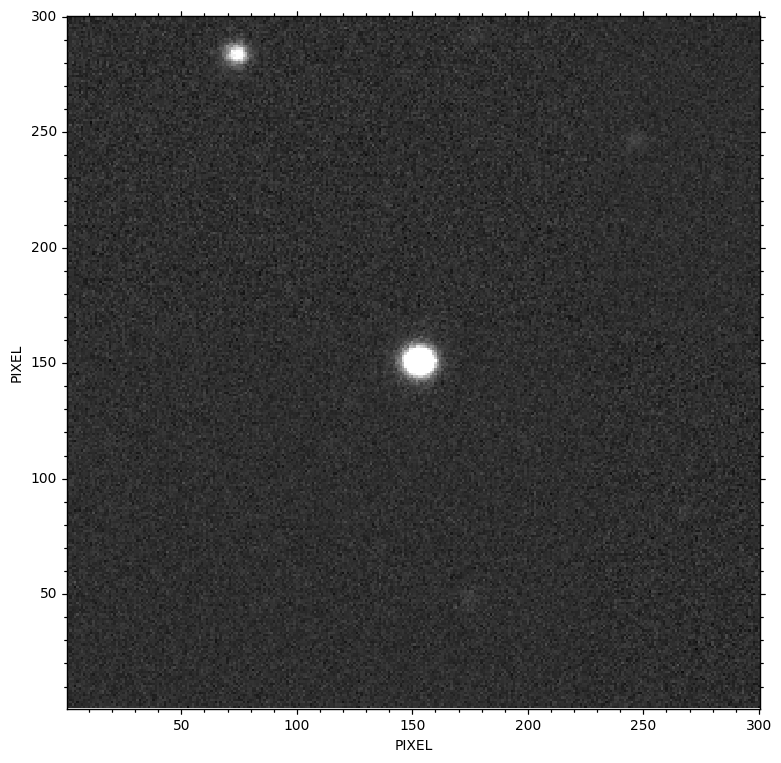

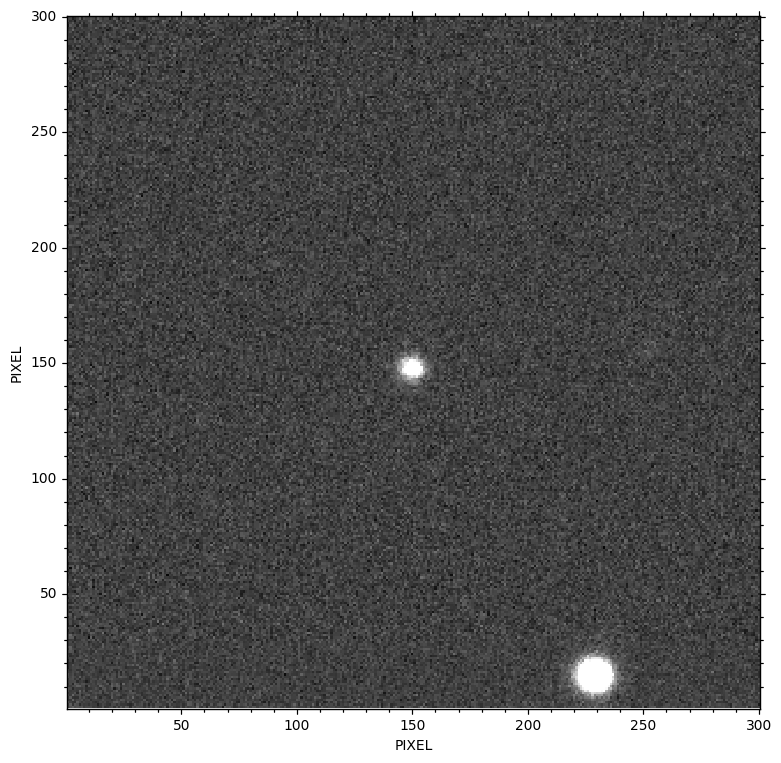

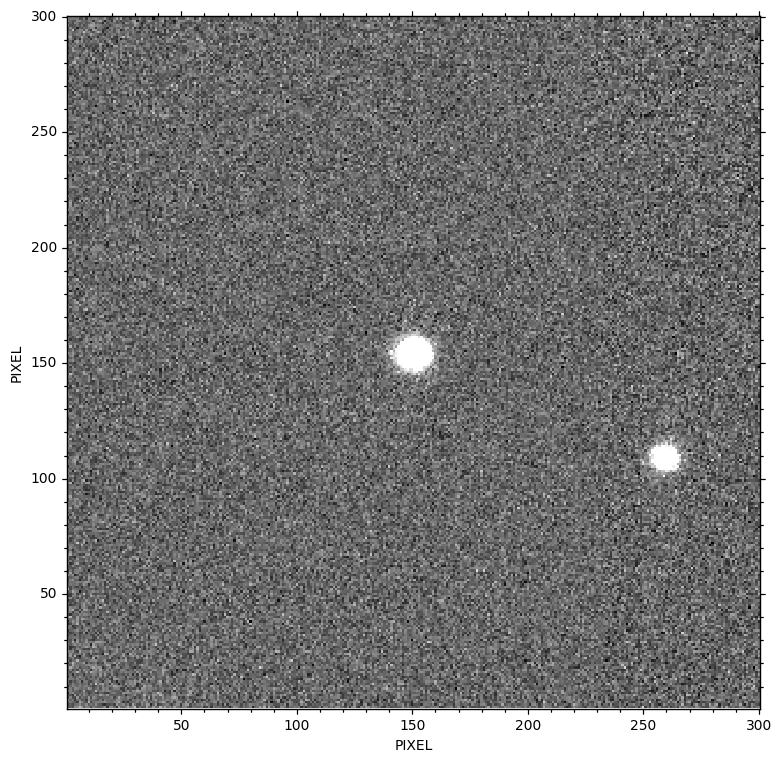

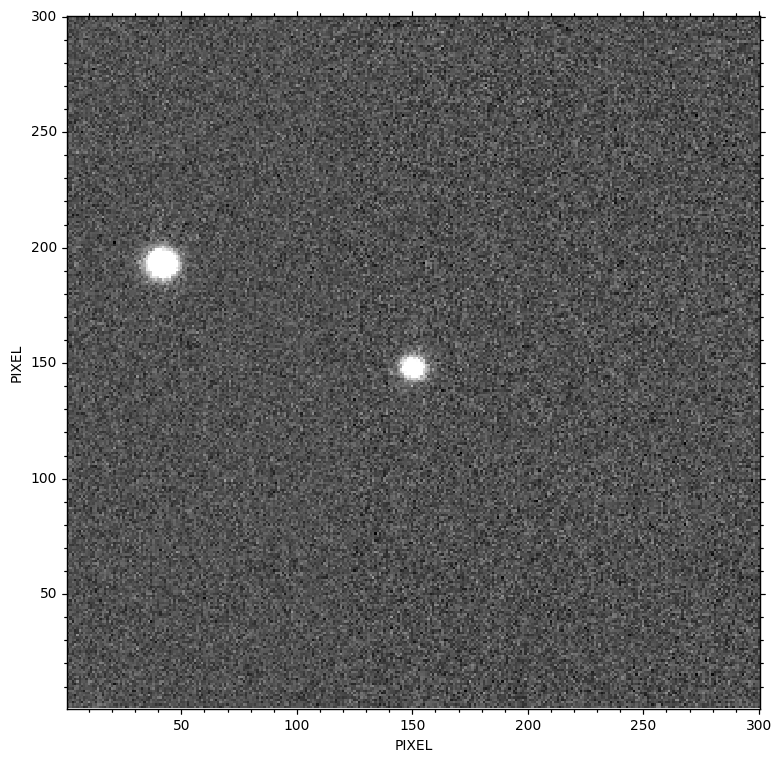

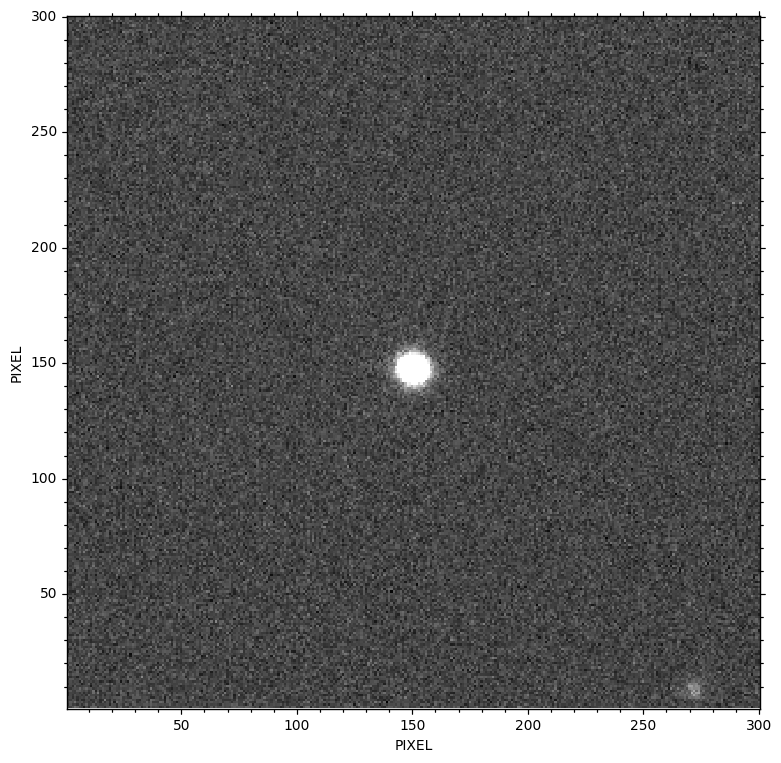

In [128]:
estrella_1 = zoom('09h45m11.8538082624s', '-03d09m22.034933164s', 300, header_BANZAI_189, data_clean_189)
estrella_2 = zoom('09h45m09.9066572376s', '-03d10m15.256881976s', 300, header_BANZAI_189, data_clean_189)
estrella_3 = zoom('09h45m11.5754495232s', '-03d06m57.161859488s', 300, header_BANZAI_189, data_clean_189)
estrella_4 = zoom('09h45m14.3872897872s', '-03d06m41.292956080s', 300, header_BANZAI_189, data_clean_189)
estrella_5 = zoom('09h45m08.6375086464s', '-03d05m55.473902440s', 300, header_BANZAI_189, data_clean_189)

imagen(estrella_1)
imagen(estrella_2)
imagen(estrella_3)
imagen(estrella_4)
imagen(estrella_5)